In [1]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


%matplotlib inline

# Ланжевен.

### Модельные данные размерности 1

В данном примере:

$$ y \sim \mathcal{N}(wx, \beta^{-1}), $$
$$ x,w \in \mathbb{R} $$

$$ w \sim \mathcal{N}(0, \alpha^{-1}) $$

Тогда апостериорная плотность:

$$ p(w| \mathcal{D}, \alpha, \beta) =  \mathcal{N}(w | \mu, \sigma^2) $$

$$ \sigma^2 = (\beta \phi^T\phi + \alpha)^{-1} $$
$$ \mu = \beta\sigma^2\phi^Ty$$

где $\phi = (x_1, ..., x_N)^T$

#### Не стохастический (по всей выборке)

In [2]:
from sklearn.datasets import make_regression
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

N, n_features, n_relevance, beta = 200, 1, 1, 0.005

X, y = make_regression(n_samples=N, n_features=n_features, n_informative=n_relevance, noise=np.sqrt(1/beta), random_state=42)

# X = StandardScaler().fit_transform(X)
# y = StandardScaler().fit_transform(y)

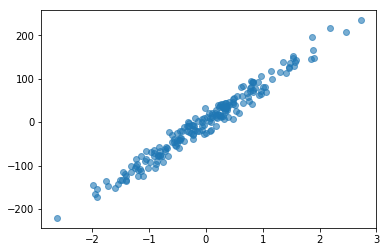

In [3]:
plt.scatter(X, y, alpha=0.6)

In [4]:
import numpy as np

rg = RidgeCV(alphas=np.logspace(-4, 4, 9))
rg.fit(X, y)
alpha = rg.alpha_ * beta
rg.score(X, y)

0.96994493932841042

In [5]:
import tensorflow as tf

In [80]:
tf.reset_default_graph()

with tf.variable_scope('variables'):
    weights = tf.get_variable('Weights', dtype=tf.float64, shape=(n_features, 1), initializer=tf.constant_initializer(0., dtype=tf.float64))
    bias = tf.get_variable('bias', dtype=tf.float64, shape=[], initializer=tf.constant_initializer(0., dtype=tf.float64))

input_x, input_y = tf.placeholder(tf.float64), tf.placeholder(tf.float64)
learning_rate = tf.placeholder(tf.float64)

logits = tf.squeeze(tf.matmul(input_x, weights)) + bias

loss = beta * tf.reduce_sum(tf.square(input_y - logits)) / tf.cast(tf.shape(input_x)[0], tf.float64) * N + alpha * tf.reduce_sum(weights **2) 

In [81]:
optimzer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimzer.minimize(loss)

noise = tf.random_normal(tf.shape(weights), dtype=tf.float64, stddev=tf.sqrt(8 * learning_rate))
with tf.control_dependencies([train_op]):
    add_noise_op = tf.assign_add(weights, noise)
    langevin_step = add_noise_op

In [82]:
session = tf.Session()
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [30]:
w_samples = []
losses = []

In [31]:
def run_op_ntimes(op, times, feed):
    for i in range(times):
        session.run(op, feed_dict=feed)

        w_samples.append(session.run(weights)[0][0])
        losses.append(session.run(loss, {
                    input_x: X,
                    input_y: y,
                }))

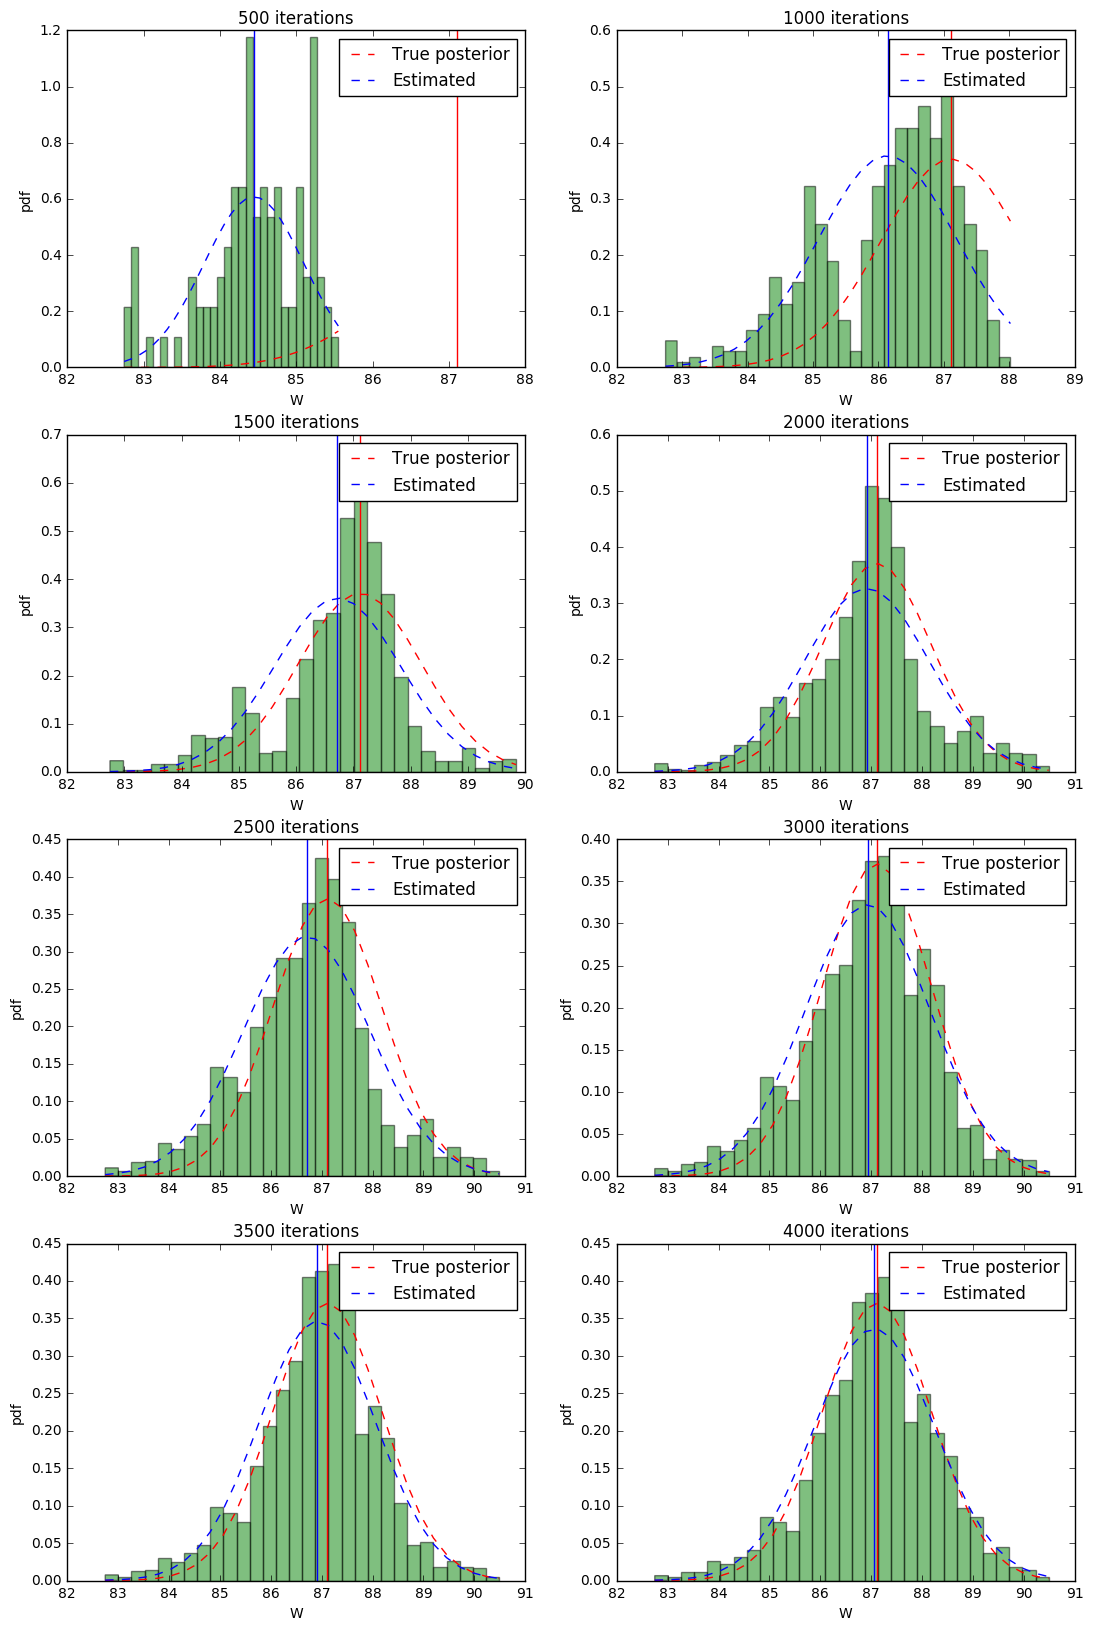

In [32]:
from scipy import stats

sigma = 1 / (beta * np.dot(X[:,0], X[:,0]) + alpha)

mu = beta * sigma * np.dot(y, X[:,0])

num_bins = 30
start = 400

ntimes = 500
LR = 0.005

plt.figure(figsize=(13, 20))
for step in range(1, 9):
    run_op_ntimes(langevin_step, ntimes, {
            input_x: X,
            input_y: y,
            learning_rate: LR
        })
    
    plt.subplot(4, 2, step)
    n, bins, patches = plt.hist(w_samples[start:], num_bins, normed=1, facecolor='green', alpha=0.5)
    pdf_post = mlab.normpdf(bins, mu, np.sqrt(sigma))
    plt.plot(bins, pdf_post, 'r--', label='True posterior')

    pdf_emperical = mlab.normpdf(bins, np.mean(w_samples[start:]), np.std(w_samples[start:], ddof=1))
    plt.plot(bins, pdf_emperical, 'b--', label='Estimated')
    
    plt.axvline(mu, c='r')
    plt.axvline(np.mean(w_samples[start:]), c='b')

    plt.xlabel('W')
    plt.ylabel('pdf')
    plt.title('{} iterations'.format(step * ntimes))
    plt.legend()

In [33]:
session.run(weights)

array([[ 89.42401337]])

In [34]:
rg.coef_

array([ 87.2077374])

#### Стохастический

In [9]:
def lr(t, a=0.1, b=10, gamma=0.55):
    return a * ((b + t) ** -gamma)

In [10]:
lr(1), lr(10000 * len(X) + 1)

(0.026744471683572836, 3.423199331365956e-05)

In [44]:
def run_nepochs(session, op, nepochs, X, y, batch_size, lr):
    for epoch in range(nepochs):
        for n in range(0, len(X), batch_size):
            session.run(op, feed_dict={
                    input_x: X[n: n + batch_size],
                    input_y: y[n: n + batch_size],
                    learning_rate: lr(epoch * len(X) + n + 1)
                })
            w_samples.append(session.run(weights)[0][0])
#             losses.append(session.run(loss, {
#                         input_x: X,
#                         input_y: y,
#                     }))

In [83]:
from scipy import stats

nepochs = 2000

session = tf.Session()
session.run(tf.initialize_all_variables())
w_samples = []
losses = []

run_nepochs(session, langevin_step, nepochs, X, y, 1, lr)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


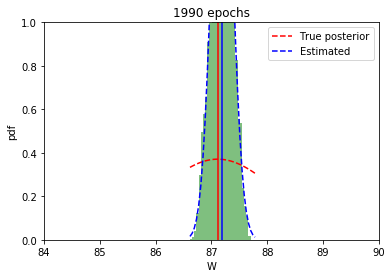

In [33]:
num_bins = 30
start = 2 * 1000

plt.ylim([0, 1.])
plt.xlim([84., 90.])

sigma = 1 / (beta * np.dot(X[:,0], X[:,0]) + alpha)

mu = beta * sigma * np.dot(y, X[:,0])

n, bins, patches = plt.hist(w_samples[start:], num_bins, normed=1, facecolor='green', alpha=0.5)
pdf_post = mlab.normpdf(bins, mu, np.sqrt(sigma))
plt.plot(bins, pdf_post, 'r--', label='True posterior')

pdf_emperical = mlab.normpdf(bins, np.mean(w_samples[start:]), np.std(w_samples[start:], ddof=1))
plt.plot(bins, pdf_emperical, 'b--', label='Estimated')

plt.axvline(mu, c='r')
plt.axvline(np.mean(w_samples[start:]), c='b')

plt.xlabel('W')
plt.ylabel('pdf')
plt.title('{} epochs'.format(nepochs - start // 200))
plt.legend()


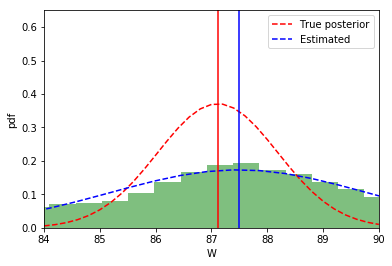

In [84]:
num_bins = 30
start = 2 * 1000

plt.ylim([0, .65])
plt.xlim([84., 90.])

sigma = 1 / (beta * np.dot(X[:,0], X[:,0]) + alpha)

mu = beta * sigma * np.dot(y, X[:,0])

n, bins, patches = plt.hist(w_samples[start:], num_bins, normed=1, facecolor='green', alpha=0.5)
pdf_post = mlab.normpdf(np.linspace(84., 90., len(bins)), mu, np.sqrt(sigma))
plt.plot(np.linspace(84., 90., len(bins)), pdf_post, 'r--', label='True posterior')

pdf_emperical = mlab.normpdf(bins, np.mean(w_samples[start:]), np.std(w_samples[start:], ddof=1))
plt.plot(bins, pdf_emperical, 'b--', label='Estimated')

plt.axvline(mu, c='r')
plt.axvline(np.mean(w_samples[start:]), c='b')

plt.xlabel('W')
plt.ylabel('pdf')
# plt.title('{} epochs'.format(nepochs - start // 200))
plt.legend()



#### Пример из статьи

$$ \theta_1 \sim \mathcal{N}(0, \sigma^2_1); \theta_2 \sim \mathcal{N}(0, \sigma^2_2) $$


$$ x \sim 0.5 \mathcal{N}(\theta_1, \sigma^2_x) + 0.5 \mathcal{N}(\theta_1 + \theta_2, \sigma^2_x)$$

Данные сгенерированы из модели $\theta_1 = 0, \theta_1 = 1$

In [110]:
theta_1 = 0
theta_2 = 1
sigma_1 = np.sqrt(10)
sigma_2 = 1
sigma_x = np.sqrt(2)

In [125]:
N = 100
c = np.random.binomial(1, 0.5, size=(N,))
locs = c * theta_2
x = np.random.normal(loc=locs, scale=sigma_x, size=(N,))

from scipy.stats import norm

def likelihood(theta_1, theta_2, sigma, x):
    return np.sum(np.log(0.5 * (norm.pdf(x - theta_1, scale=sigma) + norm.pdf(x - theta_1 - theta_2, scale=sigma))), axis=-1)

def prior(theta_1, theta_2, sigma_1, sigma_2):
    return norm.logpdf(theta_1, loc=0, scale=sigma_1) + norm.logpdf(theta_2, loc=0, scale=sigma_2)

In [133]:
th1 = np.linspace(-1.5, 3, 50)
th2 = np.linspace(-3, 3, 50)
T1, T2 = np.meshgrid(th1, th2)

In [134]:
Z = likelihood(T1[:,:,np.newaxis], T2[:,:,np.newaxis], sigma_x, x[np.newaxis, np.newaxis]) + prior(T1, T2, sigma_1, sigma_2)

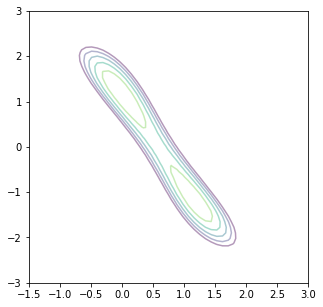

In [137]:
plt.figure(figsize=(5,5))
plt.contour(T1, T2, Z, levels=np.linspace(Z.max() - 3, Z.max(), 6), alpha=.4)

In [58]:
def lr(t, a=0.2, b=231, gamma=0.55):
    return a * ((b + t) ** -gamma)

In [143]:
lr(1), lr(10000 * len(x))

(0.010000267194944797, 0.00010022471383731374)

In [89]:
tf.reset_default_graph()

with tf.variable_scope('variables'):
    w1 = tf.get_variable('Theta_1', dtype=tf.float64, shape=[], initializer=tf.constant_initializer(0., dtype=tf.float64))
    w2 = tf.get_variable('Theta_2', dtype=tf.float64, shape=[], initializer=tf.constant_initializer(0., dtype=tf.float64))

data_sigma = tf.cast(tf.placeholder_with_default(sigma_x, []), tf.float64)




In [150]:
def condition(t, c):
    return t <= len(x)

def body(t, c, noise_ratio=1.):
    a=0.2
    b=231
    gamma=0.55
    learning_rate = a * ((b + tf.cast(c*len(x) + t, tf.float64)) ** -gamma)
    optimzer = tf.train.GradientDescentOptimizer(learning_rate / 2)

    alldata = tf.constant(x)
    input_x = alldata[tf.mod(t, len(x))]
    data = [input_x, input_x]
    
    data_dist = tf.contrib.distributions.Normal(mu=[w1, w1 + w2], sigma=[data_sigma, data_sigma])
    logpdf = tf.log(tf.reduce_mean(data_dist.pdf(data)))
    llh = logpdf * N

    params_dist = tf.contrib.distributions.Normal(mu=tf.cast([0., 0.], tf.float64), sigma=tf.cast([sigma_1, sigma_2], tf.float64))
    prior = tf.reduce_sum(params_dist.log_pdf([w1, w2]))

    loss = -llh - prior
    train_op = optimzer.minimize(loss)
    noise = tf.random_normal([2], dtype=tf.float64, stddev=tf.sqrt(learning_rate * noise_ratio))
    with tf.control_dependencies([train_op]):
        add_noise_op = tf.group(tf.assign_add(w1, tf.gather(noise, 0)), tf.assign_add(w2, tf.gather(noise, 1)))
        langevin_step = add_noise_op

    with tf.control_dependencies([langevin_step]):
        return [t + 1, c]

In [145]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [146]:
e = tf.placeholder(tf.int32)
idx = tf.placeholder(tf.int32)

loop = tf.while_loop(condition, body, [idx, e])

In [151]:
def run_langevin(epochs, nr):
    session.run(tf.global_variables_initializer())
    loop = tf.while_loop(condition, lambda t,c: body(t, c, nr) , [idx, e])
    t1, t2 = [], []
    for k in range(epochs):
        session.run(loop, {e: k, idx: 1})
        t1.append(session.run(w1))
        t2.append(session.run(w2))
    return t1, t2

CPU times: user 1h 2min 17s, sys: 43min 22s, total: 1h 45min 40s
Wall time: 2h 20min 52s


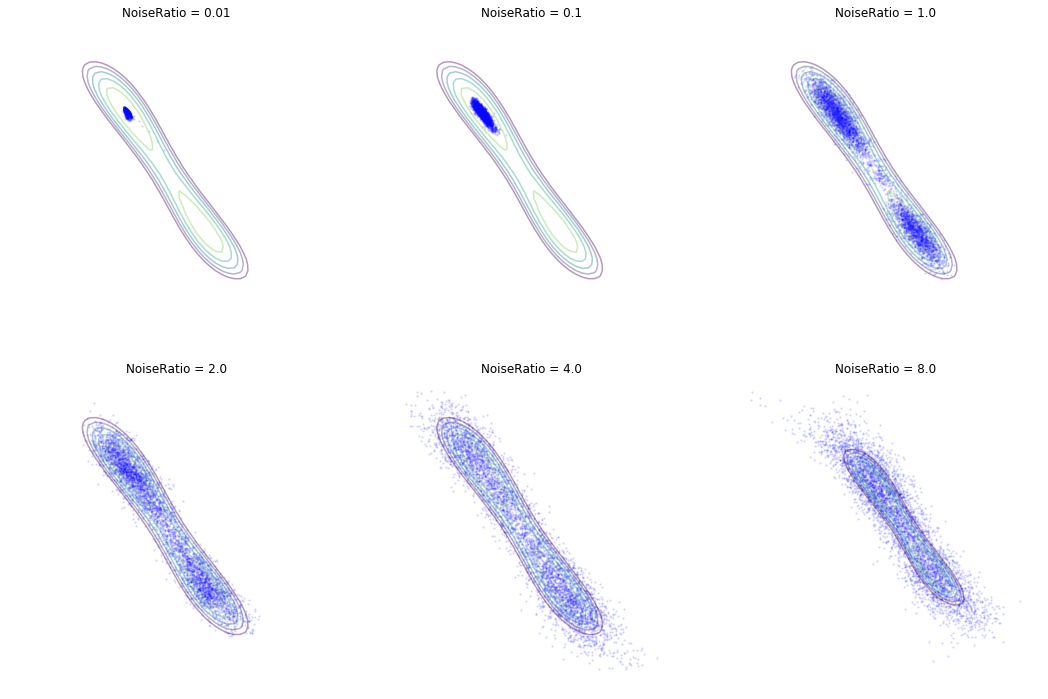

In [154]:
%%time
EPOCHS = 5000
plt.figure(figsize=(18, 12))
m, n= 2, 3
noise_ratios = [0.005, 0.05, 0.5, 1., 2., 4.]

k = 0
for i in range(1, m+1):
    for j in range(1, n+1):    
        t1, t2 = run_langevin(EPOCHS, noise_ratios[k])
    
        plt.subplot(m, n, (i - 1) * n + j)
        plt.axis('off')

        plt.scatter(t1, t2, alpha=.1, s=2, c='b')
        plt.contour(T1, T2, Z, levels=np.linspace(Z.max() - 3, Z.max(), 6), alpha=.4)
        plt.title('NoiseRatio = {}'.format(noise_ratios[k] * 2))
        k += 1

# plt.suptitle('Langevin {} epochs'.format(EPOCHS), fontsize=16)

In [155]:
1

1

CPU times: user 46.3 s, sys: 15 s, total: 1min 1s
Wall time: 18.9 s


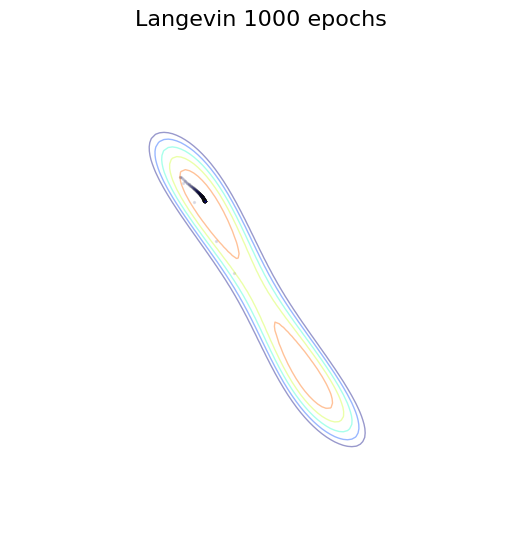

In [170]:
%%time
EPOCHS = 1000
plt.figure(figsize=(6, 6))
n, m = 1, 1
for i in range(1, m+1):
    for j in range(1, n+1):
        session.run(tf.global_variables_initializer())
        t1, t2 = run_langevin(EPOCHS)
        
        plt.subplot(m, n, (i - 1) * n + j)
        plt.axis('off')

        plt.scatter(t1, t2, alpha=.1, s=2, c='b')
        plt.contour(T1, T2, Z, levels=np.linspace(Z.max() - 3, Z.max(), 6), alpha=.4)


plt.suptitle('Langevin {} epochs'.format(EPOCHS), fontsize=16)

CPU times: user 45.9 s, sys: 14.2 s, total: 1min
Wall time: 18 s


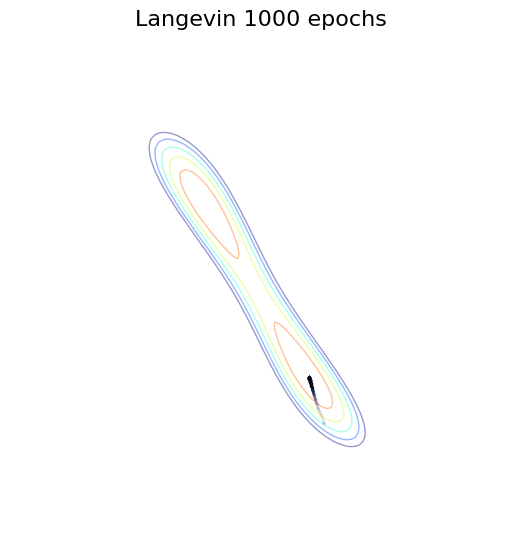

In [164]:
%%time
EPOCHS = 1000
plt.figure(figsize=(6, 6))
n, m = 1, 1
for i in range(1, m+1):
    for j in range(1, n+1):
        session.run(tf.global_variables_initializer())
        session.run(tf.assign(w1, 1.))
        session.run(tf.assign(w2, -1.5))

        t1, t2 = run_langevin(EPOCHS)
        
        plt.subplot(m, n, (i - 1) * n + j)
        plt.axis('off')

        plt.scatter(t1, t2, alpha=.1, s=2, c='b')
        plt.contour(T1, T2, Z, levels=np.linspace(Z.max() - 3, Z.max(), 6), alpha=.4)


plt.suptitle('Langevin {} epochs'.format(EPOCHS), fontsize=16)

In [171]:
th1, th2 = session.run([w1, w2])